In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix

In [95]:
data = pd.read_csv("data.csv", index_col=0)
labels = pd.read_csv("labels.csv",index_col=0)
data.head()
data.tail()
# -> 801 rows, 20264 columns
labels.tail()
np.unique(labels)
# -> 5 classes


# gene_5 only has NaN values, probably because of zero variance. Let's drop all columns with zero variance
zero_var_columns = data.columns[data.nunique() <= 1]
data = data.drop(columns=zero_var_columns)
#data.head()

#let's also convert to float32 to speed up computations
data[data.select_dtypes(include=['float64']).columns] = data.select_dtypes(include=['float64']).astype('float32')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 801 entries, sample_0 to sample_800
Columns: 20264 entries, gene_0 to gene_20530
dtypes: float32(20264)
memory usage: 61.9+ MB


In [3]:
random_seed = 12

In [15]:
data.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_6,gene_7,gene_8,gene_9,gene_10,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
sample_0,0.0,2.017209,3.265527,5.478487,10.431999,7.175175,0.591871,0.0,0.0,0.591871,...,4.926711,8.210258,9.723516,7.220030,9.119813,12.003135,9.650743,8.921327,5.286759,0.0
sample_1,0.0,0.592732,1.588421,7.586157,9.623011,6.816049,0.000000,0.0,0.0,0.000000,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
sample_2,0.0,3.511759,4.327199,6.881787,9.870730,6.972130,0.452595,0.0,0.0,0.000000,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788360,10.090469,1.683023,0.0
sample_3,0.0,3.663618,4.507649,6.659068,10.196184,7.843375,0.434882,0.0,0.0,0.000000,...,6.076566,8.792959,10.141520,8.942804,9.601208,11.392682,9.694814,9.684364,3.292001,0.0
sample_4,0.0,2.655741,2.821547,6.539454,9.738265,6.566967,0.360982,0.0,0.0,0.000000,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922440,9.217750,9.461191,5.110372,0.0


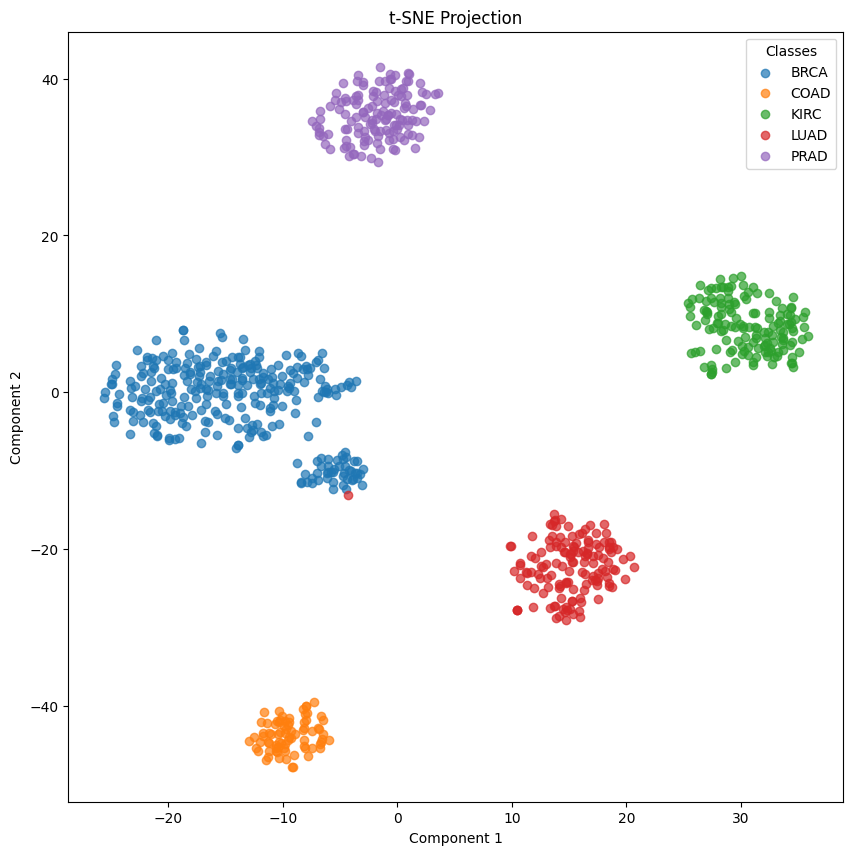

In [153]:
#this because label encoder expects a 1D array
labels_flat = labels.values.ravel()

#this because plt expects classes to be represented numerically
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_flat)

#initialize TSNE
tsne = TSNE(n_components=2, random_state=random_seed)

#fit to data
data_tsne = tsne.fit_transform(data)

# plot TSNE Projection for every unique label
plt.figure(figsize=(10, 10))
for cls in np.unique(labels_encoded):
    decoded_label = label_encoder.inverse_transform([cls])[0]
    plt.scatter(data_tsne[labels_encoded == cls, 0], data_tsne[labels_encoded == cls, 1], label=decoded_label, alpha=0.7)

plt.title('t-SNE Projection')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Classes')
plt.show()

# -> classes seem well balanced. Except maybe the -10,-40 one doesn't have much
# Also clearly separable. You can see there is that one other point in the biggest cluster, 
# so a performance metric of 1.00 should be suspicious



In [4]:
# split into trainval and test
X_trainval, X_test, y_trainval, y_test = train_test_split(data, labels, test_size=0.1, random_state=random_seed)
# split trainval into train and val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=random_seed)

y_train_flat = y_train.values.ravel()

In [26]:
# RANDOM FOREST hyperparameter tuning with 2-fold cross validation
param_grid_rf2 = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

rf = RandomForestClassifier(random_state=random_seed)

grid_search_rf2 = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=2,
                           scoring='f1_weighted',
                           n_jobs=-1,
                           verbose=2)

grid_search_rf2.fit(X_train, y_train_flat)

results_rf2 = grid_search_rf2.cv_results_
for mean_score, params in zip(results_rf2['mean_test_score'], results_rf2['params']):
    print(f"F1 Score: {mean_score:.4f} for {params}")

Fitting 2 folds for each of 24 candidates, totalling 48 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=12), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100]},
             scoring='f1_weighted', verbose=2)

In [29]:
# RANDOM FOREST hyperparameter tuning with 7-fold cross validation
param_grid_rf7 = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

rf = RandomForestClassifier(random_state=random_seed)

grid_search_rf7 = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=7,
                           scoring='f1_weighted',
                           n_jobs=-1,
                           verbose=2)

grid_search_rf7.fit(X_train, y_train_flat)

results_rf7 = grid_search_rf7.cv_results_
for mean_score, params in zip(results_rf7['mean_test_score'], results_rf7['params']):
    print(f"F1 Score: {mean_score:.4f} for {params}")

Fitting 7 folds for each of 24 candidates, totalling 168 fits


GridSearchCV(cv=7, estimator=RandomForestClassifier(random_state=12), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100]},
             scoring='f1_weighted', verbose=2)

In [5]:
# SVM hyperparameter tuning met 2-fold cross-validation

param_grid_svm2 = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3],  
    'gamma': ['scale', 'auto'], 
}

svm2 = svm.SVC() 

grid_search_svm2 = GridSearchCV(estimator=svm2,
                           param_grid=param_grid_svm2,
                           cv=2,
                           scoring='f1_weighted',
                           n_jobs=-1,
                           verbose=2)

grid_search_svm2.fit(X_train, y_train_flat)

results_svm2 = grid_search_svm2.cv_results_
for mean_score, params in zip(results_svm2['mean_test_score'], results_svm2['params']):
    print(f"F1 Score: {mean_score:.4f} for {params}")

Fitting 2 folds for each of 36 candidates, totalling 72 fits
F1 Score: 0.9985 for {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
F1 Score: 0.4119 for {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
F1 Score: 0.9938 for {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
F1 Score: 0.9985 for {'C': 0.1, 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}
F1 Score: 0.5798 for {'C': 0.1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
F1 Score: 0.9985 for {'C': 0.1, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
F1 Score: 0.9985 for {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
F1 Score: 0.4119 for {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
F1 Score: 0.9969 for {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
F1 Score: 0.9985 for {'C': 0.1, 'degree': 3, 'gamma': 'auto', 'kernel': 'linear'}
F1 Score: 0.5798 for {'C': 0.1, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}
F1 Score: 0.9985 for {'C': 0.1, 'degree': 3, 'gam

In [6]:
# SVM hyperparameter tuning met 7-fold cross-validation

param_grid_svm7 = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3],  
    'gamma': ['scale', 'auto'], 
}

svm7 = svm.SVC() 

grid_search_svm7 = GridSearchCV(estimator=svm7,
                           param_grid=param_grid_svm7,
                           cv=7,
                           scoring='f1_weighted',
                           n_jobs=-1,
                           verbose=2)

grid_search_svm7.fit(X_train, y_train_flat)

results_svm7 = grid_search_svm7.cv_results_
for mean_score, params in zip(results_svm7['mean_test_score'], results_svm7['params']):
    print(f"F1 Score: {mean_score:.4f} for {params}")

Fitting 7 folds for each of 36 candidates, totalling 252 fits
F1 Score: 0.9984 for {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
F1 Score: 0.6726 for {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
F1 Score: 0.9938 for {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
F1 Score: 0.9984 for {'C': 0.1, 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}
F1 Score: 0.8445 for {'C': 0.1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
F1 Score: 0.9984 for {'C': 0.1, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
F1 Score: 0.9984 for {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
F1 Score: 0.6726 for {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
F1 Score: 0.9984 for {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
F1 Score: 0.9984 for {'C': 0.1, 'degree': 3, 'gamma': 'auto', 'kernel': 'linear'}
F1 Score: 0.8445 for {'C': 0.1, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}
F1 Score: 0.9984 for {'C': 0.1, 'degree': 3, 'ga

In [37]:
# kNN hyperparameter tuning with 2-fold cross validation
param_grid_knn2 = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

knn2 = KNeighborsClassifier()

grid_search_knn2 = GridSearchCV(estimator=knn2,
                                 param_grid=param_grid_knn2,
                                 cv=2,
                                 scoring='f1_weighted',
                                 n_jobs=-1,
                                 verbose=2)

grid_search_knn2.fit(X_train, y_train_flat)

results_knn2 = grid_search_knn2.cv_results_
for mean_score, params in zip(results_knn2['mean_test_score'], results_knn2['params']):
    print(f"F1 Score: {mean_score:.4f} for {params}")

Fitting 2 folds for each of 32 candidates, totalling 64 fits
F1 Score: 0.9969 for {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'uniform'}
F1 Score: 0.9969 for {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
F1 Score: 0.9938 for {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'}
F1 Score: 0.9938 for {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'}
F1 Score: 0.9954 for {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'uniform'}
F1 Score: 0.9954 for {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'distance'}
F1 Score: 0.9938 for {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'uniform'}
F1 Score: 0.9954 for {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'}
F1 Score: 0.9969 for {'algorithm': 'ball_tree', 'n_neighbors': 3, 'weights': 'uniform'}
F1 Score: 0.9969 for {'algorithm': 'ball_tree', 'n_neighbors': 3, 'weights': 'distance'}
F1 Score: 0.9938 for {'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'uniform'}
F1 S

In [38]:
# kNN hyperparameter tuning with 7-fold cross validation
param_grid_knn7 = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

knn7 = KNeighborsClassifier()

grid_search_knn7 = GridSearchCV(estimator=knn7,
                                 param_grid=param_grid_knn7,
                                 cv=7,
                                 scoring='f1_weighted',
                                 n_jobs=-1,
                                 verbose=2)

grid_search_knn7.fit(X_train, y_train_flat)

results_knn7 = grid_search_knn7.cv_results_
for mean_score, params in zip(results_knn7['mean_test_score'], results_knn7['params']):
    print(f"F1 Score: {mean_score:.4f} for {params}")

Fitting 7 folds for each of 32 candidates, totalling 224 fits
F1 Score: 0.9969 for {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'uniform'}
F1 Score: 0.9969 for {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
F1 Score: 0.9969 for {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'}
F1 Score: 0.9969 for {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'}
F1 Score: 0.9969 for {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'uniform'}
F1 Score: 0.9969 for {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'distance'}
F1 Score: 0.9969 for {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'uniform'}
F1 Score: 0.9969 for {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'}
F1 Score: 0.9969 for {'algorithm': 'ball_tree', 'n_neighbors': 3, 'weights': 'uniform'}
F1 Score: 0.9969 for {'algorithm': 'ball_tree', 'n_neighbors': 3, 'weights': 'distance'}
F1 Score: 0.9969 for {'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'uniform'}
F1 

In [49]:
# best Random Forest
best_rf = RandomForestClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50, random_state=random_seed)
best_rf.fit(X_train, y_train_flat)
y_pred_val = best_rf.predict(X_val)
f1 = f1_score(y_val, y_pred_val, average='weighted')
print(f'F1 Score: {f1}')
cm = confusion_matrix(y_val, y_pred_val)
print(f"Confusion Matrix:\n{cm}")

F1 Score: 1.0
Confusion Matrix:
[[25  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0 15  0  0]
 [ 0  0  0 11  0]
 [ 0  0  0  0 16]]


In [42]:
# best SVM
best_svm = svm.SVC(C=0.1, gamma='scale', kernel='linear', random_state=random_seed)
best_svm.fit(X_train, y_train_flat)

y_pred_val = best_svm.predict(X_val)
f1 = f1_score(y_val, y_pred_val, average='weighted')
print(f'F1 Score: {f1}')
cm = confusion_matrix(y_val, y_pred_val)
print(f"Confusion Matrix:\n{cm}")

F1 Score: 1.0
Confusion Matrix:
[[25  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0 15  0  0]
 [ 0  0  0 11  0]
 [ 0  0  0  0 16]]


In [69]:
#PCA transform
pca = PCA(n_components = min(data.shape[0], data.shape[1]))
pca_result = pca.fit_transform(data)

# Cumulative variance explained
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
print(explained_variance_ratio)

# split into trainval and test
pcaX_trainval, pcaX_test, pcay_trainval, pcay_test = train_test_split(pca_result, labels, test_size=0.1, random_state=random_seed)
# split trainval into train and val
pcaX_train, pcaX_val, pcay_train, pcay_val = train_test_split(pcaX_trainval, pcay_trainval, test_size=0.1, random_state=random_seed)

pcay_train_flat = pcay_train.values.ravel()

[0.15838563 0.26342523 0.35814747 0.4231555  0.45931166 0.48903832
 0.51560974 0.53123707 0.5453078  0.55757654 0.56717765 0.57607985
 0.5836619  0.59089214 0.59753215 0.6039093  0.6096042  0.61477995
 0.61940116 0.62385625 0.62829083 0.63235515 0.63630986 0.64004177
 0.6437273  0.64728415 0.650769   0.6539362  0.65704    0.65999234
 0.66288453 0.66564745 0.66837853 0.670999   0.67351305 0.6760242
 0.67843056 0.6807873  0.68310905 0.6853635  0.6875836  0.6897585
 0.69187987 0.6939833  0.6960693  0.6981122  0.70007694 0.70203424
 0.7039684  0.7058597  0.7076774  0.70946264 0.7112203  0.7129473
 0.7146514  0.716331   0.71797353 0.7196023  0.7212149  0.7227949
 0.7243663  0.72592115 0.72746366 0.72897637 0.7304594  0.731936
 0.73339283 0.73482335 0.7362226  0.7376085  0.73898214 0.74034965
 0.74169016 0.74302346 0.74434245 0.7456485  0.7469421  0.7482335
 0.74950844 0.7507729  0.75201863 0.75325114 0.75447094 0.75568515
 0.7568941  0.7580775  0.7592472  0.7603992  0.76154864 0.76268536
 0

In [102]:
# best_RF met verschillende hoeveelheden PCA-transformed features (LET OP: deze berekening duurt lang)
best_rf = RandomForestClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50, random_state=random_seed)

features = range(1, pcaX_train.shape[1])
f1_scores_rf_pca = np.zeros(pcaX_train.shape[1])


for i in range(1,pcaX_train.shape[1]+1):
    best_rf.fit(pcaX_train[:, :i], pcay_train_flat)
    pcay_pred_val = best_rf.predict(pcaX_val[:, :i])
    f1 = f1_score(pcay_val, pcay_pred_val, average='weighted')
    f1_scores_rf_pca[i-1] = f1

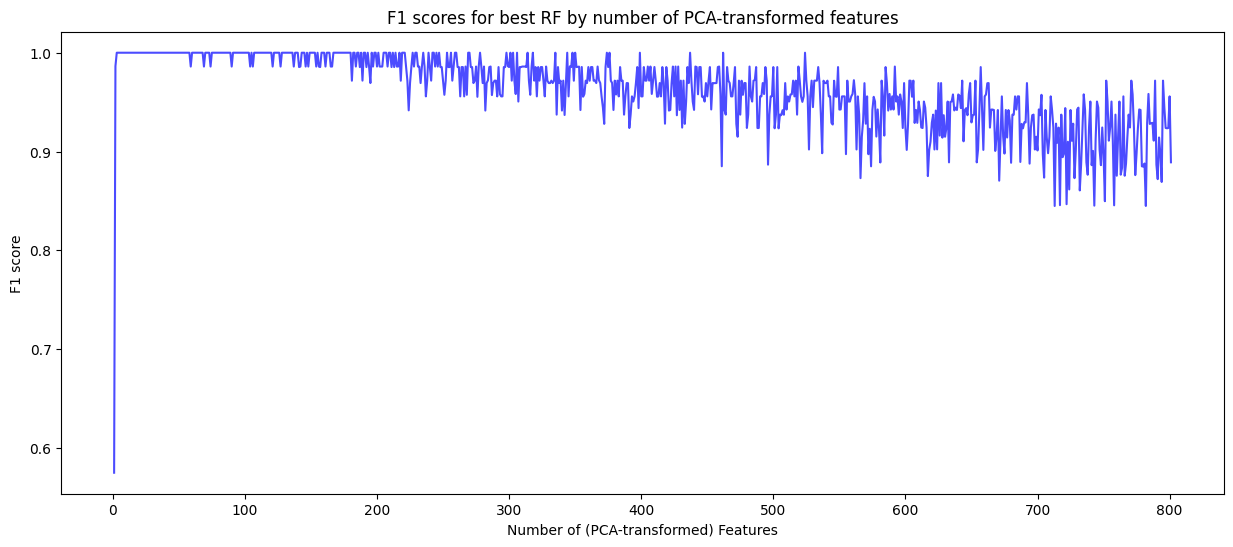

In [156]:
# Plot best_rf performance vs no of PCA-transformed features
x_values = np.arange(1,802)

plt.figure(figsize=(15,6))
plt.plot(x_values, f1_scores_rf_pca, linestyle='-', color='b', alpha=0.7)
plt.title('F1 scores for best RF by number of PCA-transformed features')
plt.xlabel('Number of (PCA-transformed) Features')
plt.ylabel('F1 score')
plt.show()

In [143]:
# best_SVM met verschillende hoeveelheden PCA_transformed features
best_svm = svm.SVC(C=0.1, gamma='scale', kernel='linear', random_state=random_seed)

#features = range(1, pcaX_train.shape[1])

# set max features
max_features = 25

#eerst maar een lege array want dat is efficienter
f1_scores_svm_pca = np.zeros(min(max_features, pcaX_train.shape[1]))


for i in range(1,min(max_features, pcaX_train.shape[1])+1):
    best_svm.fit(pcaX_train[:, :i], pcay_train_flat)
    pcay_pred_val = best_svm.predict(pcaX_val[:, :i])
    f1 = f1_score(pcay_val, pcay_pred_val, average='weighted')
    f1_scores_svm_pca[i-1] = f1

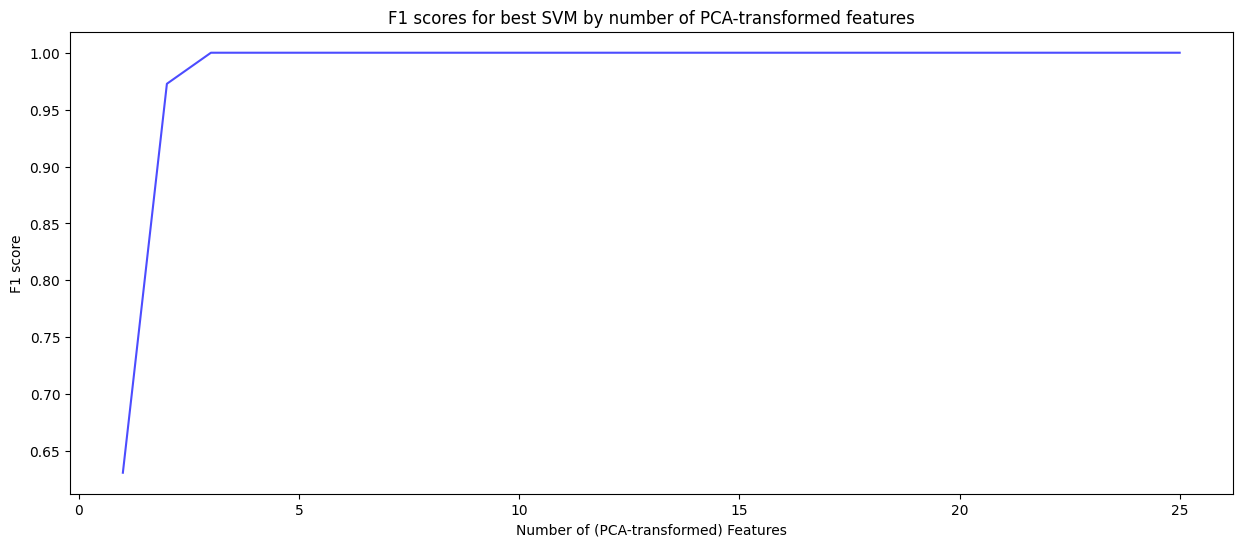

In [155]:
# Plot best_svm performance vs no. of PCA transformed features
x_values = np.arange(1,min(max_features, pcaX_train.shape[1])+1)

plt.figure(figsize=(15,6))
plt.plot(x_values, f1_scores_svm_pca, linestyle='-', color='b', alpha=0.7)
plt.title('F1 scores for best SVM by number of PCA-transformed features')
plt.xlabel('Number of (PCA-transformed) Features')
plt.ylabel('F1 score')
plt.show()

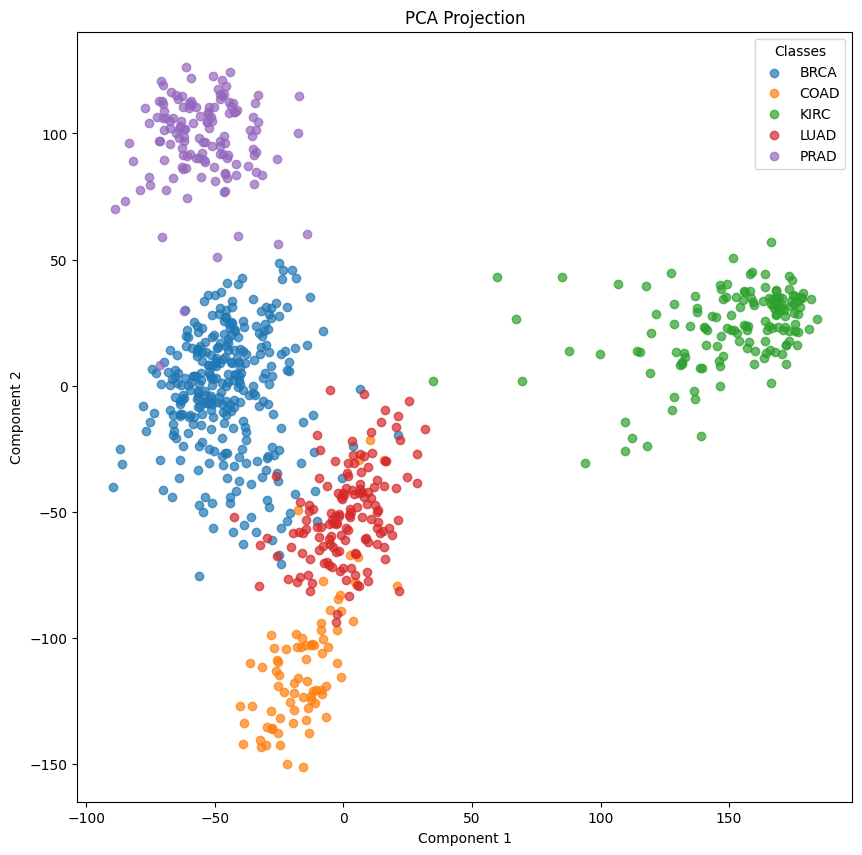

In [154]:
# FURTHER EXPLORATION OF PCA TRANSFORM

# wat zijn die eerste waarden nou precies?
f1_scores_rf_pca
f1_scores_svm_pca
# ok dat betekent dat we met twee features al een performance hebben van 98.64% en 92.27%. Hoe ziet de data eruit in deze 2-dimensional space?

# drop de andere 798 features
pca_result_2d = pca_result[:,:2]

# plot PCA-2 Projection for every unique label
plt.figure(figsize=(10, 10))
for cls in np.unique(labels_encoded):
    decoded_label = label_encoder.inverse_transform([cls])[0]
    plt.scatter(pca_result_2d[labels_encoded == cls, 0], pca_result_2d[labels_encoded == cls, 1], label=decoded_label, alpha=0.7)

plt.title('PCA Projection')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Classes')
plt.show()

#ok it does do a pretty good job separating the clusters, so I can imagine adding a third dimension already bumps up the F1 score to 1.0

In [110]:
# calculate mutual information for every feature (takes a while)
mutual_info = mutual_info_classif(X_train, y_train_flat)

In [168]:
#SORT COLUMNS BY MUTUAL INFORMATION

# convert to pandas df because X_train is one as well
mutual_info_df = pd.DataFrame(mutual_info, index=X_train.columns, columns=['Mutual Information'])

mi_sorted = mutual_info_df.sort_values(by='Mutual Information', ascending=False)
miX_train = X_train[mi_sorted.index]
miX_val = X_val[mi_sorted.index]

In [166]:
# CALCULATE F1 SCORES FOR RANDOM FOREST USING DIFFERENT AMOUNTS OF FEATURES (sorted by mutual information)

# set top k features for mutual information (mi) calculation
mi_k = 50

# best_RF met verschillende hoeveelheden mi-sorted features
best_rf = RandomForestClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50, random_state=random_seed)

#initialize f1 array
f1_scores_rf_mi = np.zeros(mi_k)


for i in range(1,mi_k+1):
    best_rf.fit(miX_train.iloc[:, :i], y_train_flat)
    y_pred_val = best_rf.predict(miX_val.iloc[:, :i])
    f1 = f1_score(y_val, y_pred_val, average='weighted')
    f1_scores_rf_mi[i-1] = f1

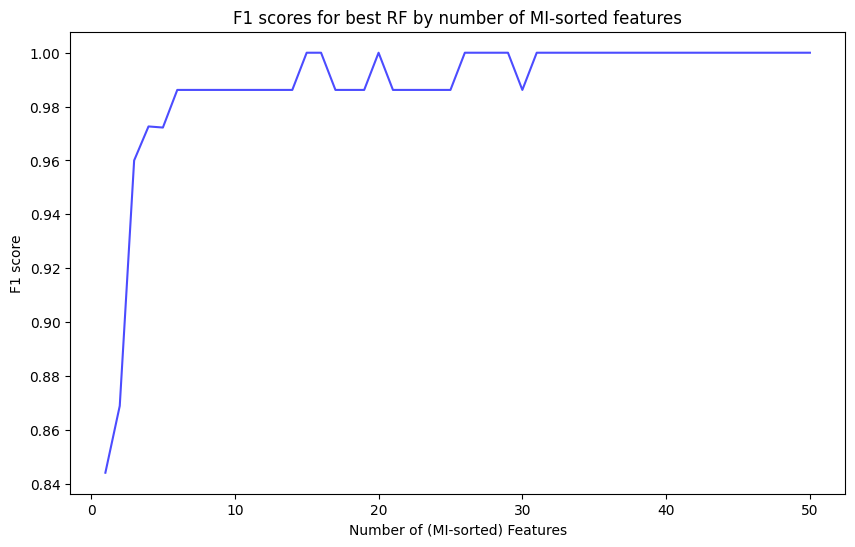

In [136]:
# Plot best_rf performance vs no of mi-sorted features
x_values = np.arange(1,mi_k+1)

plt.figure(figsize=(10,6))
plt.plot(x_values, f1_scores_rf_mi, linestyle='-', color='b', alpha=0.7)
plt.title('F1 scores for best RF by number of MI-sorted features')
plt.xlabel('Number of (MI-sorted) Features')
plt.ylabel('F1 score')
plt.show()

In [140]:
# CALCULATE F1 SCORES FOR SVM USING DIFFERENT AMOUNTS OF FEATURES (sorted by mutual information)

# set top k features for mutual information (mi) calculation
mi_k = 50

# best_RF met verschillende hoeveelheden mi-sorted features
best_svm = svm.SVC(C=0.1, gamma='scale', kernel='linear', random_state=random_seed)

#initialize f1 array
f1_scores_svm_mi = np.zeros(mi_k)


for i in range(1,mi_k+1):
    best_svm.fit(miX_train.iloc[:, :i], y_train_flat)
    y_pred_val = best_svm.predict(miX_val.iloc[:, :i])
    f1 = f1_score(y_val, y_pred_val, average='weighted')
    f1_scores_svm_mi[i-1] = f1

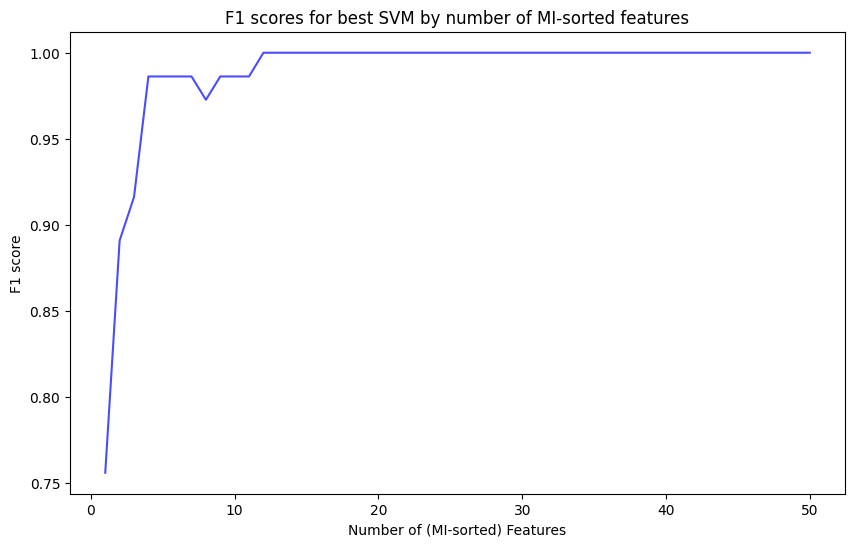

In [142]:
# Plot best_rf performance vs no of mi-sorted features
x_values = np.arange(1,mi_k+1)

plt.figure(figsize=(10,6))
plt.plot(x_values, f1_scores_svm_mi, linestyle='-', color='b', alpha=0.7)
plt.title('F1 scores for best SVM by number of MI-sorted features')
plt.xlabel('Number of (MI-sorted) Features')
plt.ylabel('F1 score')
plt.show()

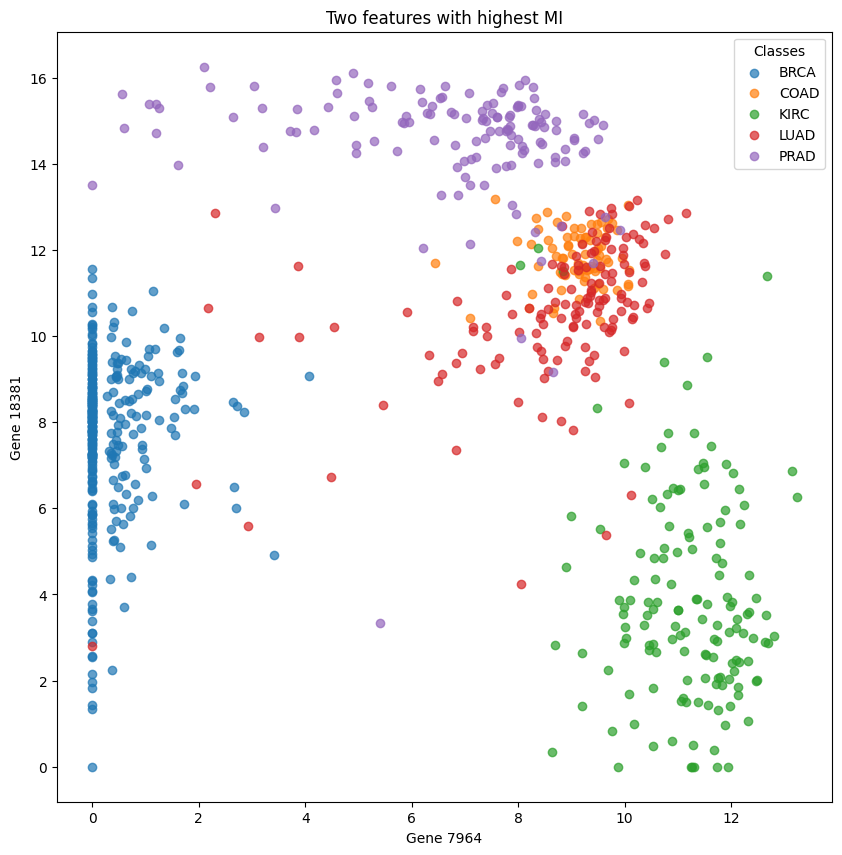

In [191]:
#FURTHER EXPLORATION OF MUTUAL INFORMATION

#ok voor de beste random forest heb je met twee features met de hoogste MI al een F1 van 89,07% en met de beste SVM 86,88%
# hoe separable zijn de classes in deze twee features?
miX = data[mi_sorted.index]
miX_2d = miX.iloc[:,:2]
miX_2d = miX_2d.to_numpy()

# plot PCA-2 Projection for every unique label
plt.figure(figsize=(10, 10))
for cls in np.unique(labels_encoded):
    decoded_label = label_encoder.inverse_transform([cls])[0]
    plt.scatter(miX_2d[labels_encoded == cls, 0],miX_2d[labels_encoded == cls, 1], label=decoded_label, alpha=0.7)

plt.title('Two features with highest MI')
plt.xlabel('Gene 7964')
plt.ylabel('Gene 18381')
plt.legend(title='Classes')
plt.show()

#ok so with just two genes we can already separate pretty reliably between every pair except COAD and LUAD